In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train_V2.csv', 'test_V2.csv', 'sample_submission_V2.csv']


# XGB BOOST

In [2]:
import numpy as np
import gc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn import svm
#from catboost import CatBoostRegressor
from xgboost import plot_importance
import featuretools as ft

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


 # CSV TO HDF

In [3]:
import pandas as pd
import numpy as np
#https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(props):
    NAlist = []
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()  
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)     
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)          
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float16)
    return props, NAlist

In [5]:
df = pd.read_csv('../input/train_V2.csv')
df, nan = reduce_mem_usage(df)

In [6]:
df.to_hdf('train_V2.hdf', 'data', format='table')

In [7]:

test = pd.read_csv('../input/test_V2.csv')
test, na = reduce_mem_usage(test)
test.to_hdf('test_V2.hdf', 'data', format='table')

In [8]:

df_train = pd.read_hdf('train_V2.hdf')

In [9]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            uint8
boosts             uint8
damageDealt        float16
DBNOs              uint8
headshotKills      uint8
heals              uint8
killPlace          uint8
killPoints         uint16
kills              uint8
killStreaks        uint8
longestKill        float16
matchDuration      uint16
matchType          object
maxPlace           uint8
numGroups          uint8
rankPoints         int16
revives            uint8
rideDistance       float16
roadKills          uint8
swimDistance       float16
teamKills          uint8
vehicleDestroys    uint8
walkDistance       float16
weaponsAcquired    uint8
winPoints          uint16
winPlacePerc       float16
dtypes: float16(6), int16(1), object(4), uint16(3), uint8(15)
memory usage: 1.3 GB


In [10]:
for dtype in df_train.dtypes.unique():
    selected_dtype = df_train.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for object columns: 241.97 MB
Average memory usage for uint8 columns: 6.10 MB
Average memory usage for float16 columns: 12.12 MB
Average memory usage for uint16 columns: 14.84 MB
Average memory usage for int16 columns: 21.20 MB


In [11]:
df_train, NAlist = reduce_mem_usage(df_train)

In [12]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            uint8
boosts             uint8
damageDealt        float16
DBNOs              uint8
headshotKills      uint8
heals              uint8
killPlace          uint8
killPoints         uint16
kills              uint8
killStreaks        uint8
longestKill        float16
matchDuration      uint16
matchType          object
maxPlace           uint8
numGroups          uint8
rankPoints         int16
revives            uint8
rideDistance       float16
roadKills          uint8
swimDistance       float16
teamKills          uint8
vehicleDestroys    uint8
walkDistance       float16
weaponsAcquired    uint8
winPoints          uint16
winPlacePerc       float16
dtypes: float16(6), int16(1), object(4), uint16(3), uint8(15)
memory usage: 1.3 GB


In [14]:
train = df_train
del df_train
gc.collect()

142

In [15]:

# Get the # of numerical and categorical feature
numerical_feats = train.dtypes[train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))
categorical_feats = train.dtypes[train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))
numerical_feats

Number of Numerical features:  25
Number of Categorical features:  4


Index(['assists', 'boosts', 'damageDealt', 'DBNOs', 'headshotKills', 'heals',
       'killPlace', 'killPoints', 'kills', 'killStreaks', 'longestKill',
       'matchDuration', 'maxPlace', 'numGroups', 'rankPoints', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

In [16]:
train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4446966.00,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4446966.0,4.446966e+06,4.446966e+06,4446966.000,4.446966e+06,4.446966e+06,4.446966e+06
mean,2.338149e-01,1.106908e+00,NaN,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,NaN,1.579506e+03,4.450467e+01,4.300759e+01,8.920105e+02,1.646590e-01,NaN,3.496091e-03,NaN,2.386841e-02,7.918208e-03,NaN,3.660488e+00,6.064601e+02,NaN
std,5.885731e-01,1.715794e+00,NaN,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,NaN,2.587399e+02,2.382811e+01,2.328949e+01,7.366478e+02,4.721671e-01,NaN,7.337297e-02,NaN,1.673935e-01,9.261157e-02,NaN,2.456544e+00,7.397004e+02,0.000000e+00
min,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+00,1.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.367000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,155.125,2.000000e+00,0.000000e+00,1.999512e-01
50%,0.000000e+00,0.000000e+00,84.25,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.443000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,685.500,3.000000e+00,0.000000e+00,4.582520e-01
75%,0.000000e+00,2.000000e+00,186.00,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,2.131250e+01,1.851000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,1.910095e-01,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1976.000,5.000000e+00,1.495000e+03,7.407227e-01
max,2.200000e+01,3.300000e+01,6616.00,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.910000e+03,3.900000e+01,4.070400e+04,1.800000e+01,3824.0,1.200000e+01,5.000000e+00,25776.000,2.360000e+02,2.013000e+03,1.000000e+00


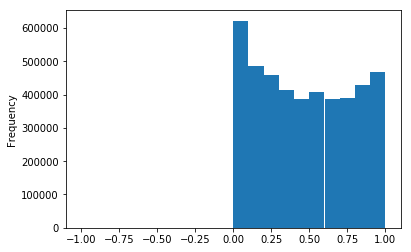

In [17]:
train['winPlacePerc'].plot.hist(bins=20)

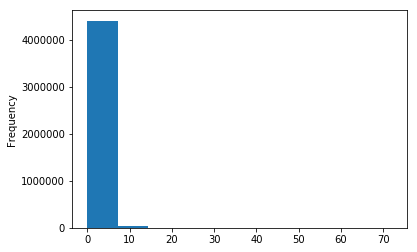

In [18]:
train['kills'].plot.hist(bins=10)

Skew: 3.362906895966635
Kurt: 27.43876918713356


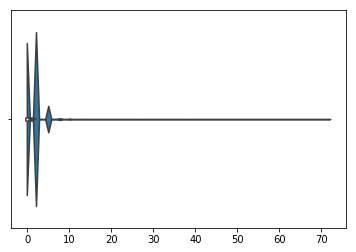

In [19]:
ax = sns.violinplot(x=train['kills'].values)
print('Skew: {}'.format(train['kills'].skew()))
print('Kurt: {}'.format(train['kills'].kurt()))

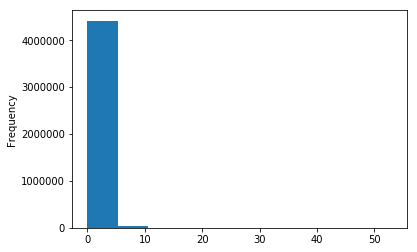

In [20]:
train['DBNOs'].plot.hist(bins=10)

Skew: 3.2015366326154737
Kurt: 22.830951393147608


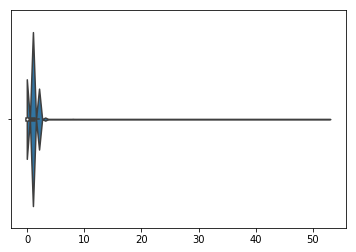

In [21]:
ax = sns.violinplot(x=train['DBNOs'].values)
print('Skew: {}'.format(train['DBNOs'].skew()))
print('Kurt: {}'.format(train['DBNOs'].kurt()))

Skew: 3.5676085924463434
Kurt: 21.230739855982062


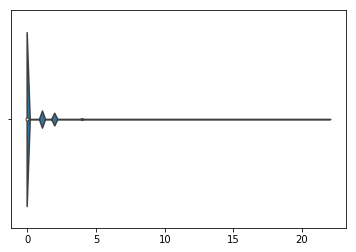

In [22]:
ax = sns.violinplot(x=train['assists'].values)
print('Skew: {}'.format(train['assists'].skew()))
print('Kurt: {}'.format(train['assists'].kurt()))

Skew: 1.9499586070317043
Kurt: 4.2994392461199915


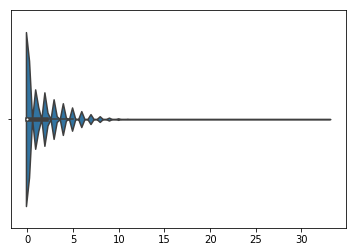

In [23]:
ax = sns.violinplot(x=train['boosts'].values)
print('Skew: {}'.format(train['boosts'].skew()))
print('Kurt: {}'.format(train['boosts'].kurt()))

Skew: nan
Kurt: nan


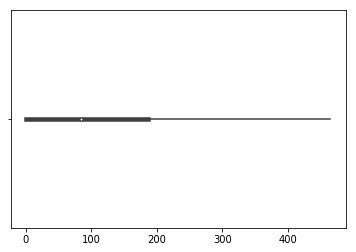

In [24]:
ax = sns.violinplot(x=train['damageDealt'].values)
print('Skew: {}'.format(train['damageDealt'].skew()))
print('Kurt: {}'.format(train['damageDealt'].kurt()))

Skew: 5.218260894138295
Kurt: 106.21359702543587


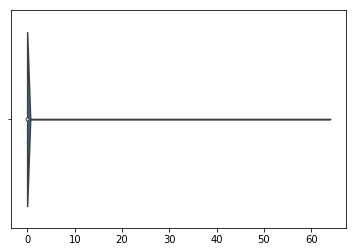

In [25]:
ax = sns.violinplot(x=train['headshotKills'].values)
print('Skew: {}'.format(train['headshotKills'].skew()))
print('Kurt: {}'.format(train['headshotKills'].kurt()))

Skew: 3.4443449731926346
Kurt: 18.699277116989695


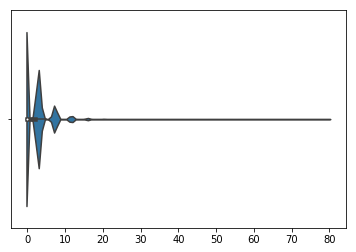

In [26]:
ax = sns.violinplot(x=train['heals'].values)
print('Skew: {}'.format(train['heals'].skew()))
print('Kurt: {}'.format(train['heals'].kurt()))

Skew: 36.93492082941069
Kurt: 2967.783837971672


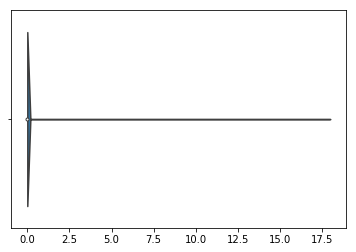

In [27]:
ax = sns.violinplot(x=train['roadKills'].values)
print('Skew: {}'.format(train['roadKills'].skew()))
print('Kurt: {}'.format(train['roadKills'].kurt()))

Skew: nan
Kurt: nan


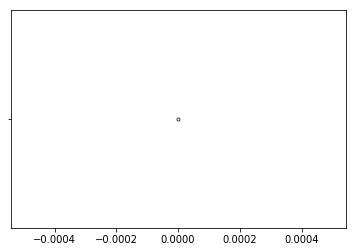

In [28]:
ax = sns.violinplot(x=train['swimDistance'].values)
print('Skew: {}'.format(train['swimDistance'].skew()))
print('Kurt: {}'.format(train['swimDistance'].kurt()))

Skew: 8.19419099855793
Kurt: 91.11038574762166


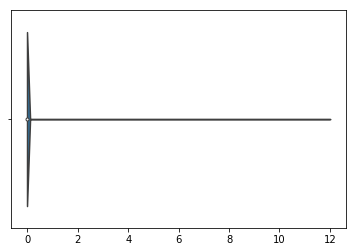

In [29]:
ax = sns.violinplot(x=train['teamKills'].values)
print('Skew: {}'.format(train['teamKills'].skew()))
print('Kurt: {}'.format(train['teamKills'].kurt()))

Skew: 8.19419099855793
Kurt: 91.11038574762166


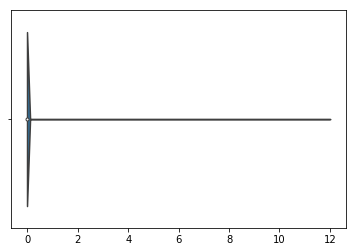

In [30]:
ax = sns.violinplot(x=train['teamKills'].values)
print('Skew: {}'.format(train['teamKills'].skew()))
print('Kurt: {}'.format(train['teamKills'].kurt()))

Skew: 12.723040144828381
Kurt: 189.39344801220662


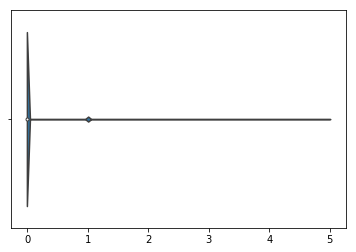

In [31]:
ax = sns.violinplot(x=train['vehicleDestroys'].values)
print('Skew: {}'.format(train['vehicleDestroys'].skew()))
print('Kurt: {}'.format(train['vehicleDestroys'].kurt()))

Skew: nan
Kurt: nan


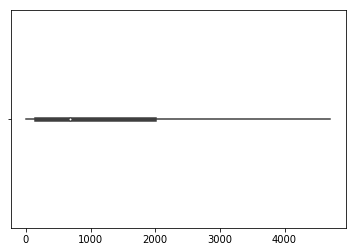

In [32]:
ax = sns.violinplot(x=train['walkDistance'].values)
print('Skew: {}'.format(train['walkDistance'].skew()))
print('Kurt: {}'.format(train['walkDistance'].kurt()))

Skew: 2.5723067419429184
Kurt: 59.35548228267442


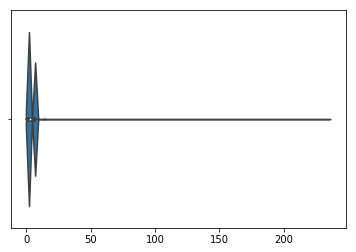

In [33]:
ax = sns.violinplot(x=train['weaponsAcquired'].values)
print('Skew: {}'.format(train['weaponsAcquired'].skew()))
print('Kurt: {}'.format(train['weaponsAcquired'].kurt()))

Skew: 0.4053582384905466
Kurt: -1.8254206795127026


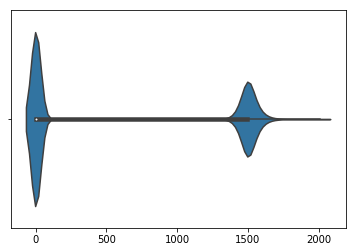

In [34]:
ax = sns.violinplot(x=train['winPoints'].values)
print('Skew: {}'.format(train['winPoints'].skew()))
print('Kurt: {}'.format(train['winPoints'].kurt()))

Skew: 1.3616523300256396
Kurt: 0.5360734768343609


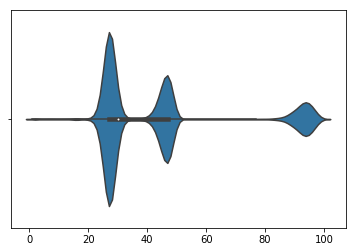

In [35]:

ax = sns.violinplot(x=train['numGroups'].values)
print('Skew: {}'.format(train['numGroups'].skew()))
print('Kurt: {}'.format(train['numGroups'].kurt()))

Skew: 1.35472177968696
Kurt: 0.4867224848727716


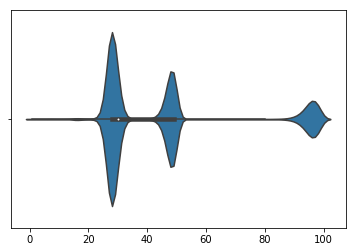

In [36]:
ax = sns.violinplot(x=train['maxPlace'].values)
print('Skew: {}'.format(train['maxPlace'].skew()))
print('Kurt: {}'.format(train['maxPlace'].kurt()))

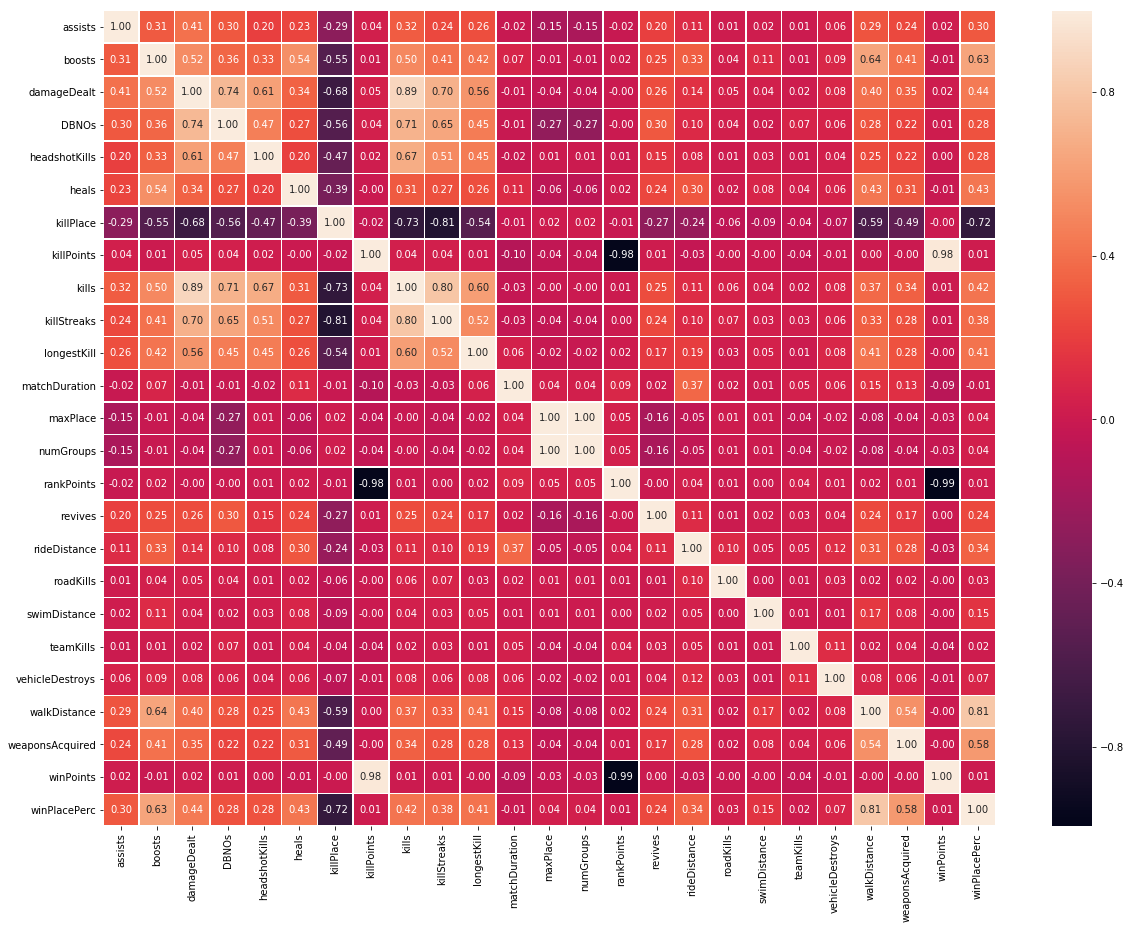

In [37]:
# bivariate analysis

f, ax = plt.subplots(figsize=(20,15))
sns.heatmap(train.corr(), annot=True, fmt='.2f', linewidths=.5, ax=ax)

In [38]:
# Feature Engineering

train_feat = train.drop(columns={'winPlacePerc', 'groupId','matchId'})
es = ft.EntitySet(id='placement')
es.entity_from_dataframe(entity_id='pubg', dataframe=train_feat, index='Id')
es.normalize_entity(base_entity_id='pubg', new_entity_id='chickenDinner', index='Id')

Entityset: placement
  Entities:
    pubg [Rows: 4446966, Columns: 26]
    chickenDinner [Rows: 4446966, Columns: 1]
  Relationships:
    pubg.Id -> chickenDinner.Id

In [ ]:
feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='pubg', verbose=1)

Built 171 features


In [ ]:
rain_feat = train.drop(columns={'winPlacePerc', 'Id', 'groupId','matchId'})

train_feat['headshot/kills'] = train_feat['headshotKills'] / train['kills']
train_feat['headshot/kills'].fillna(0, inplace=True)
train_feat['headshot/kills'].replace(np.inf, 0, inplace=True)

train_feat['maxPlace/killPlace'] = train_feat['maxPlace'] / train['killPlace']
train_feat['maxPlace/killPlace'].fillna(0, inplace=True)
train_feat['maxPlace/killPlace'].replace(np.inf, 0, inplace=True)

train_feat['walkDistance/killPlace'] = train_feat['walkDistance'] / train['killPlace']
train_feat['walkDistance/killPlace'].fillna(0, inplace=True)
train_feat['walkDistance/killPlace'].replace(np.inf, 0, inplace=True)

train_feat['walkDistance/maxPlace'] = train_feat['walkDistance'] / train['maxPlace']
train_feat['walkDistance/maxPlace'].fillna(0, inplace=True)
train_feat['walkDistance/maxPlace'].replace(np.inf, 0, inplace=True)

train_feat['kill/damageDealt'] = train_feat['kills'] / train['damageDealt']
train_feat['kill/damageDealt'].fillna(0, inplace=True)
train_feat['kill/damageDealt'].replace(np.inf, 0, inplace=True)

train_feat['passive'] = train_feat['assists'] + train_feat['heals'] + train_feat['DBNOs'] + train_feat['revives'] \
+ train_feat['boosts']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x = train_feat.iloc[0:100000]
y = train['winPlacePerc'].iloc[0:100000]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
train_sizes, train_scores, validation_scores = learning_curve(
                                                   estimator = XGBRegressor(), X = x,
                                                   y = y, cv = 5, scoring = 'neg_mean_absolute_error',
                                                   shuffle=True)

train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

In [ ]:
plt.style.use('seaborn')

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()

In [ ]:
model = XGBRegressor()
model.fit(x,y)
plot_importance(model)
plt.show()

In [ ]:
test = pd.read_hdf('test_v2.hdf')
test, NAlist = reduce_mem_usage(test)
submit = pd.DataFrame()
submit['Id'] = test['Id'].copy(deep=True)

In [ ]:
test.drop(columns={'Id', 'groupId','matchId'}, inplace=True)
test['headshot/kills'] = test['headshotKills'] / train['kills']
test['headshot/kills'].fillna(0, inplace=True)
test['headshot/kills'].replace(np.inf, 0, inplace=True)

test['maxPlace/killPlace'] = test['maxPlace'] / test['killPlace']
test['maxPlace/killPlace'].fillna(0, inplace=True)
test['maxPlace/killPlace'].replace(np.inf, 0, inplace=True)

test['walkDistance/killPlace'] = test['walkDistance'] / train['killPlace']
test['walkDistance/killPlace'].fillna(0, inplace=True)
test['walkDistance/killPlace'].replace(np.inf, 0, inplace=True)

test['walkDistance/maxPlace'] = test['walkDistance'] / train['maxPlace']
test['walkDistance/maxPlace'].fillna(0, inplace=True)
test['walkDistance/maxPlace'].replace(np.inf, 0, inplace=True)

test['kill/damageDealt'] = test['kills'] / train['damageDealt']
test['kill/damageDealt'].fillna(0, inplace=True)
test['kill/damageDealt'].replace(np.inf, 0, inplace=True)

test['passive'] = test['assists'] +test['heals'] + test['DBNOs'] + test['revives'] \
+ test['boosts']

In [ ]:
submit['winPlacePerc'] = model.predict(test)

In [ ]:
submit.to_csv('submission.csv',index=False)